# Sample Molecular Dynamics (MD) simulation code for LJ particle
## NPT ensemble by Nose-Poincare-Andersen method
2018, 2019, May, Tsuyoshi Okubo  
2021, May, modified by Tsuyoshi Okubo  
2022, May, modified by Tsuyoshi Okubo  


By using Nose-Andersen method, we can simulate molucular dynamics under constant temperae and constant pressure (NPT ensemble).
In this codes, we combine Nose-Poincare and  Andersen methods. In this algorithm, an extended Hamiltoninan including thermostad and piston degree of freedoms $H_{NPA}$ is expected to be conserved. Here $H_{NPA}$ is given by

$$ H_{NPA} = s\left\{ \sum_{i} \frac{\tilde{p}_i^{\prime 2}}{2m_is^2V^{2/3}} +\sum_{i} U(V^{1/3}\tilde{q_i})+ \frac{P_s^2}{2Q} + gk_BT_0\log s + \frac{P_V^2}{2M} + P_0V - H_0\right\},\\
= s\left\{H_{NA} - H_0\right\}$$

where 
* $T_0$ and  $P_0$: desired temperature and pressure, respectively
* $s$: scale factor for time (used in temperature control)
* $\tilde{q}_i = V^{1/3} q_i$ and $\tilde{p}_i^\prime = sV^{-1/3} p_i$ : scaled coodinate and scaled momentum
* $m_i$ : mass 
* $P_s$ and  $Q$: momentum of the heat bath and its mass, respectively
* $P_V$ and  $M$: momuntum of the piston and its mass, respectively
* $H_0$ initial value of $H_{NA}$

Note that from the definition, $H_{NA} - H_0$ is also expected to be conserved. 

In this code you can simulate dynamics of LJ particles by the Nose-Poincare-Andersen method. 
You can change four physical conditions:
* **N** : the number of particles
* **rho** : the initical density
* **T_set** : desired temperature
* **P_set** : desired pressure

For simulation parameter you can set
* **dt** : time step for integral
* **thermalization**: integral time steps for thermalizaiton. Total thermalization time is dt * thermalization.
* **observation**: integral time steps for overservation. Total observation time is dt * observation.
* **output_step**: physical quantities are observed with this interval, both for the thermalization and the observation.
* **Nose_Q** and **Andersen_M**: masses for thermastad and piston, respectively

For auto correlation functions
* **correlation_step**: The longest time (MD steps) for plotting the auto-correlation fuctions.
    * In order to obtain more accurate auto correlation fuctions, you may need to increase total simulation time.

Ref. 奥村久士, 「分子動力学シミュレーションにおける温度・圧力制御」、分子シミュレーション研究会会誌 “アンサンブル” (2008, 2009).

In [14]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from numba import jit, f8, i8 ## for speed up, we use jit compile

In [21]:
## parameters for system
N=1000 # number of particles
rho = 1.0 #number density at the initial state
T_set = 1.0 # temperature 
P_set = 5.0 # pressure

## parameters for integration
dt = 0.005 
thermalization = 2000 
observation = 2000
output_step = 2

## parameters for Nose-Andersen algorithm
Nose_Q = 1.0
Andersen_M = 0.01

## parameter for auto correlation
correlation_step = 100

In [22]:
## initialization of parameter
L = (N/rho)**(1.0/3.0)

## variables for Temeperature
s = 1.0
Ps = 0.0
Nose_g = 3.0 * N

## variables for Pressure
Va = L**3
Pa = 0.0


In [23]:
@jit(nopython = True)
def periodic_boundary(x):
    if np.abs(x) > 0.5:
        x -= np.sign(x)
    return x

@jit(nopython = True)
def periodic_boundary_all(x):
    for i in range(N):
        x[i] = periodic_boundary(x[i])
    return x

@jit(nopython = True)
def force_lj(rx,ry,rz,L,r2_cut=2.5**2):
    ## calculate force, energy and virial for the LJ potential
    L_square = L**2
    r2_inv = 1.0/r2_cut
    r6_inv = r2_inv**3
    pot_base = 4.0 * r6_inv * (r6_inv - 1.0)
    r2_cut_tilde = r2_cut/L_square
    
    fx = np.zeros(N)
    fy = np.zeros(N)
    fz = np.zeros(N)
    Ep = 0.0
    virial = 0.0
    for i in range(N):
        for j in range(i+1,N):
            xij = periodic_boundary(rx[i]-rx[j])
            yij = periodic_boundary(ry[i]-ry[j])
            zij = periodic_boundary(rz[i]-rz[j])
            r2 = xij**2 + yij**2 + zij**2
            if r2 < r2_cut_tilde:
                r2 *= L_square
                r2_inv = 1.0/r2
                r6_inv = r2_inv**3
                
                f_factor = 48.0 * r6_inv * (r6_inv - 0.5)/r2
                fxi = f_factor * xij
                fyi = f_factor * yij
                fzi = f_factor * zij

                fx[i] += fxi
                fy[i] += fyi
                fz[i] += fzi

                fx[j] -= fxi
                fy[j] -= fyi
                fz[j] -= fzi

                Ep += 4.0 * r6_inv * (r6_inv - 1.0) - pot_base
                virial += fxi * xij + fyi * yij + fzi * zij
                
    
    fx *= L
    fy *= L
    fz *= L
    virial *= L_square
    Ep /= N
    return fx,fy,fz,Ep,virial

In [24]:
@jit
def Velocity_Verlet(rx,ry,rz,px,py,pz,fx,fy,fz,dt,L):
    dt2 = dt * 0.5 * L
    dt_L = dt/L**2
    ## v: t + dt/2, r: t+dt
    px += fx * dt2
    py += fy * dt2
    pz += fz * dt2

    rx += px * dt_L
    ry += py * dt_L
    rz += pz * dt_L

    rx = periodic_boundary_all(rx)
    ry = periodic_boundary_all(ry)
    rz = periodic_boundary_all(rz)
    fx,fy,fz,Ep,virial = force_lj(rx,ry,rz,L)

    ## v: t + dt/2 + dt/2
    px += fx * dt2
    py += fy * dt2
    pz += fz * dt2

    Ek = (0.5 * np.sum(px**2 + py**2 + pz**2)/N)/L**2
    
    return rx,ry,rz,px,py,pz,fx,fy,fz,Ep,Ek,virial

In [25]:
@jit(nopython = True)
def Nose_Andersen(rx,ry,rz,px,py,pz,fx,fy,fz,s,Ps,Va,Pa,Ep,virial,dt,H0,T_set,P_set,Nose_Q,Nose_g,Andersen_M):
    L = Va**(1.0/3.0)
    dt2 = dt * 0.5

    ####
    factor = (1.0 + Ps/(2.0*Nose_Q) * dt2)
    s *= factor**2
    Ps /= factor
    ####

    ####
    dt2s = dt2 * s * L
    px += fx * dt2s
    py += fy * dt2s
    pz += fz * dt2s
    
    Ps -= (Ep * N + P_set * Va) * dt2
    Pa += s * (virial / (3.0 * Va) - P_set) * dt2
    ####
    
    ####
    Ps -= Pa**2/(2.0 * Andersen_M) * dt2
    Va += s * Pa / Andersen_M * dt2
    L = Va**(1.0/3.0)
    ####
    
    ####
    dts = dt /(s * L**2)
    
    rx += px * dts
    ry += py * dts
    rz += pz * dts

    Ek = 0.5 * np.sum(px**2 + py**2 + pz**2)/(L*s)**2
    
    Ps += (Ek - Nose_g * T_set * (np.log(s) + 1.0) + H0) * dt
    Pa += Ek * 2.0 * s/(3.0 * Va) * dt
    #####

    ####
    Ps -= Pa**2/(2.0 * Andersen_M) * dt2
    Va += s * Pa / Andersen_M * dt2
    L = Va**(1.0/3.0)
    ####

    ####
    rx = periodic_boundary_all(rx)
    ry = periodic_boundary_all(ry)
    rz = periodic_boundary_all(rz)
    fx,fy,fz,Ep,virial = force_lj(rx,ry,rz,L)

    dt2s = dt2 * s* L
    px += fx * dt2s
    py += fy * dt2s
    pz += fz * dt2s

    Ps -= (Ep * N + P_set * Va) * dt2 
    Pa += s * (virial / (3.0 * Va) - P_set) * dt2
    ####
    
    ####
    factor = (1.0 + Ps/(2.0 * Nose_Q) * dt2)
    s *=  factor**2
    Ps /= factor
    ####
    
    Ek = (0.5 * np.sum(px**2 + py**2 + pz**2)/N)/(L*s)**2

    return rx,ry,rz,px,py,pz,fx,fy,fz,s,Ps,Va,Pa,Ep,Ek,virial

In [29]:
## initialization of variables
## simple cubic
rx = np.zeros(N)
ry = np.zeros(N)
rz = np.zeros(N)

px = np.zeros(N)
py = np.zeros(N)
pz = np.zeros(N)


l = N**(1.0/3.0)
nl = int(np.floor(l))+1
d = 1.0/nl

ix = np.zeros(N,dtype=int)
iy = np.zeros(N,dtype=int)
iz = np.zeros(N,dtype=int)
for i in range(N):
    iz[i] = i/nl**2
    iy[i] = (i-iz[i] * nl**2)/nl
    ix[i] = i%nl
rx = -0.5  + d * ix + 0.5/L
ry = -0.5  + d * iy + 0.5/L
rz = -0.5  + d * iz + 0.5/L

rx = periodic_boundary_all(rx)
ry = periodic_boundary_all(ry)
rz = periodic_boundary_all(rz)
fx,fy,fz,Ep,virial = force_lj(rx,ry,rz,L)


#Ek = 0.5 * np.sum(px**2 + py**2 + pz**2)/N/(L*s)**2
#Pressure = (2.0 * N * Ek + virial)/(3.0*Va)
#print("Initial, Ek: "+repr(Ek) + ", Ep: "+repr(Ep) + ", Total: "+repr(Ep+Ek))
#print("Initial, Temp: "+repr(2*Ek/3)+", Pressure: "+repr(Pressure))

## short time relaxation
for i in range(100):
    rx,ry,rz,px,py,pz,fx,fy,fz,Ep,Ek,virial = Velocity_Verlet(rx,ry,rz,px,py,pz,fx,fy,fz,dt,L)

#Ek = 0.5 * np.sum(px**2 + py**2 + pz**2)/N/(L*s)**2
#Pressure = (2.0 * N * Ek + virial)/(3.0*Va)
#print("Relaxed, Ek: "+repr(Ek) + ", Ep: "+repr(Ep) + ", Total: "+repr(Ep+Ek))
#print("Relaxed, Temp: "+repr(2*Ek/3)+", Pressure: "+repr(Pressure))




Initial, Ek: 0.0, Ep: -3.3296608014919107, Total: -3.3296608014919107
Initial, Temp: 0.0, Pressure: 16.843283841910726
Relaxed, Ek: 6.148505734313366e-28, Ep: -3.329660801491889, Total: -3.329660801491889
Relaxed, Temp: 4.099003822875577e-28, Pressure: 16.843283841910687


In [30]:
%%time
## main simulation part
#H0 = (Ek + Ep)*N + Ps**2/(2.0 * Nose_Q) + Nose_g * T_set * np.log(s) + Pa**2/(2.0 * Andersen_M) + P_set * Va
#for i in range(initial_warming_up):
#    rx,ry,rz,px,py,pz,fx,fy,fz,s,Ps,Va,Pa,Ep,Ek,virial = Nose_Andersen(rx,ry,rz,px,py,pz,fx,fy,fz,s,Ps,Va,Pa,Ep,virial,dt,H0,T_set,P_set,Nose_Q,Nose_g,Andersen_M)
#
Pressure = (2.0 * N * Ek + virial)/(3.0*Va)

## H0 is a conserved quantity (Energy) for Nose-Andersen algorithm
H0 = (Ek + Ep)*N + Ps**2/(2.0 * Nose_Q) + Nose_g * T_set * np.log(s) + Pa**2/(2.0 * Andersen_M) + P_set * Va
H_NA =H0
H_NPA = s* (H_NA - H0)

Ep_dyn = [Ep]
Ek_dyn = [Ek]
Pressure_dyn = [Pressure]

s_dyn = [s]
Ps_dyn = [Ps]

Va_dyn = [Va]
Pa_dyn = [Pa]

H_NA_dyn = [H_NA]
H_NPA_dyn = [H_NPA]


for i in range(thermalization+observation):
    rx,ry,rz,px,py,pz,fx,fy,fz,s,Ps,Va,Pa,Ep,Ek,virial = Nose_Andersen(rx,ry,rz,px,py,pz,fx,fy,fz,s,Ps,Va,Pa,Ep,virial,dt,H0,T_set,P_set,Nose_Q,Nose_g,Andersen_M)
    
    if i % output_step == 0:
        Pressure = (2.0 * N * Ek + virial)/(3.0*Va)
        H_NA = ((Ek + Ep)*N + Ps**2/(2.0 * Nose_Q) + Nose_g * T_set * np.log(s) + Pa**2/(2.0 * Andersen_M) + P_set * Va)
        H_NPA = s* (H_NA - H0)
    
        Ep_dyn.append(Ep)
        Ek_dyn.append(Ek)
        Pressure_dyn.append(Pressure)
        s_dyn.append(s)
        Ps_dyn.append(Ps)
        Va_dyn.append(Va)
        Pa_dyn.append(Pa)
        H_NA_dyn.append(H_NA)
        H_NPA_dyn.append(H_NPA)


CPU times: user 20.7 s, sys: 136 ms, total: 20.8 s
Wall time: 21.3 s


## Physical quantities
In the followings, you can see dynamics of physicsal quantities.

Note that after initial "turbulence", temperature and pressure are controled as the set values.
In adittion, expected conserved quantity $H_{NA}$ and $H_{NPA}$ become stable without any drift behaviors.

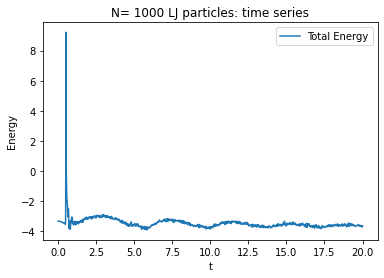

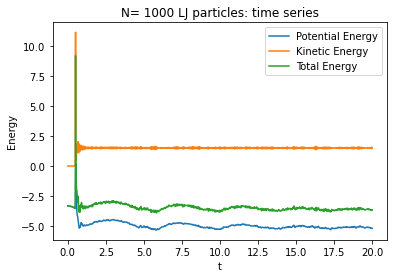

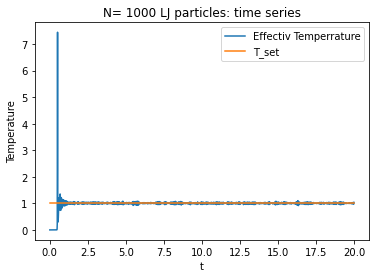

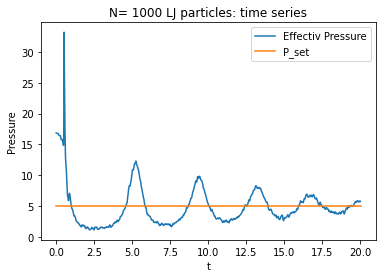

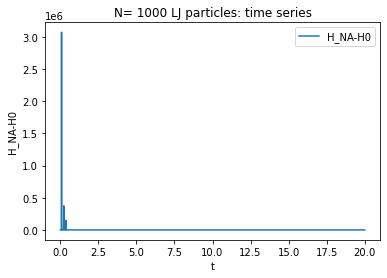

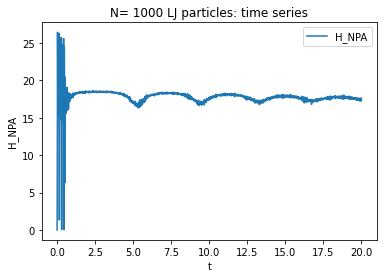

In [31]:
## plot time series
Ep = np.array(Ep_dyn)
Ek = np.array(Ek_dyn)
Pressure = np.array(Pressure_dyn)
H_NA = np.array(H_NA_dyn)-H0
H_NPA = np.array(H_NPA_dyn)

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Energy")
pyplot.plot(np.arange(Ek.size)*dt*output_step,Ek+Ep,label="Total Energy")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Energy")
pyplot.plot(np.arange(Ep.size)*dt*output_step,Ep,label="Potential Energy")
pyplot.plot(np.arange(Ek.size)*dt*output_step,Ek,label="Kinetic Energy")
pyplot.plot(np.arange(Ek.size)*dt*output_step,Ek+Ep,label="Total Energy")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Temperature")
pyplot.plot(np.arange(Ek.size)*dt*output_step,2.0*Ek/3.0,label="Effectiv Temperrature")
pyplot.plot([0, Ep.size*dt*output_step], [T_set, T_set],label="T_set")

pyplot.legend()


pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Pressure")
pyplot.plot(np.arange(Pressure.size)*dt*output_step,Pressure,label="Effectiv Pressure")
pyplot.plot([0, Ep.size*dt*output_step], [P_set, P_set],label="P_set")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("H_NA-H0")
pyplot.plot(np.arange(H_NA.size)*dt*output_step,H_NA,label="H_NA-H0")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("H_NPA")
pyplot.plot(np.arange(H_NPA.size)*dt*output_step,H_NPA,label="H_NPA")
pyplot.legend()



pyplot.show()




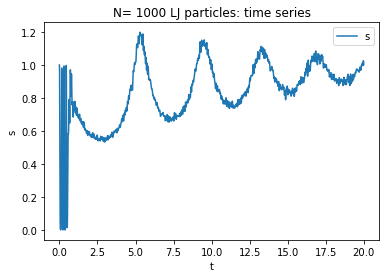

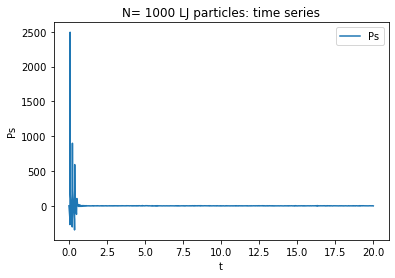

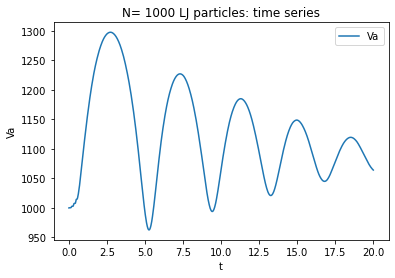

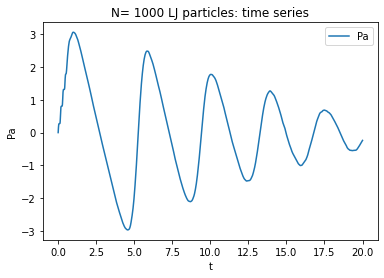

In [32]:
## plot thermostad and piston variables
s = np.array(s_dyn)
Ps = np.array(Ps_dyn)
Va = np.array(Va_dyn)
Pa = np.array(Pa_dyn)

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("s")
pyplot.plot(np.arange(s.size)*dt*output_step,s,label="s")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Ps")
pyplot.plot(np.arange(Ps.size)*dt*output_step,Ps,label="Ps")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Va")
pyplot.plot(np.arange(Va.size)*dt*output_step,Va,label="Va")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Pa")
pyplot.plot(np.arange(Pa.size)*dt*output_step,Pa,label="Pa")
pyplot.legend()

pyplot.show()


In the followings, you can see dynamics of physicsal quantities **after the thermalization**.


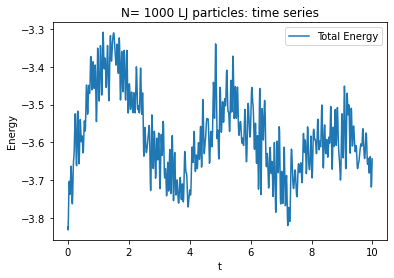

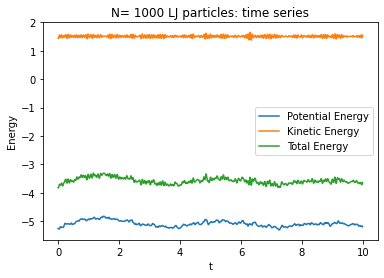

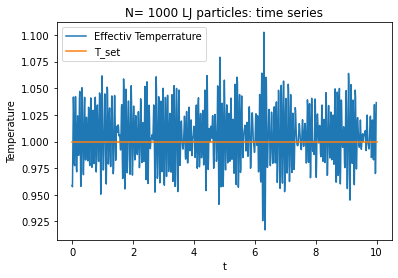

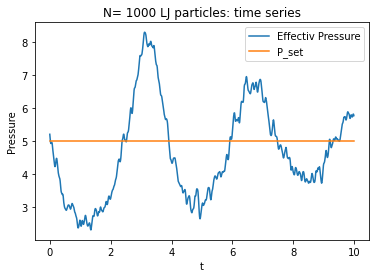

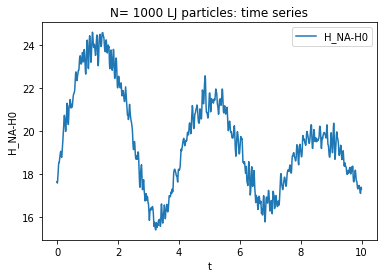

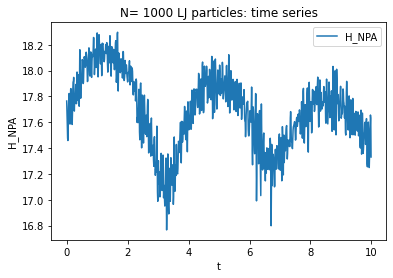

In [33]:
thermal_step = thermalization // output_step
observ_step = observation // output_step

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Energy")
pyplot.plot(np.arange(observ_step)*dt*output_step,(Ek+Ep)[thermal_step+1:],label="Total Energy")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Energy")
pyplot.plot(np.arange(observ_step)*dt*output_step,Ep[thermal_step+1:],label="Potential Energy")
pyplot.plot(np.arange(observ_step)*dt*output_step,Ek[thermal_step+1:],label="Kinetic Energy")
pyplot.plot(np.arange(observ_step)*dt*output_step,(Ek+Ep)[thermal_step+1:],label="Total Energy")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Temperature")
pyplot.plot(np.arange(observ_step)*dt*output_step,2.0*Ek[thermal_step+1:]/3.0,label="Effectiv Temperrature")
pyplot.plot([0, observ_step*dt*output_step], [T_set, T_set],label="T_set")
pyplot.legend()


pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Pressure")
pyplot.plot(np.arange(observ_step)*dt*output_step,Pressure[thermal_step+1:],label="Effectiv Pressure")
pyplot.plot([0, observ_step*dt*output_step], [P_set, P_set],label="P_set")
pyplot.legend()


pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("H_NA-H0")
pyplot.plot(np.arange(observ_step)*dt*output_step,H_NA[thermal_step+1:],label="H_NA-H0")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("H_NPA")
pyplot.plot(np.arange(observ_step)*dt*output_step,H_NPA[thermal_step+1:],label="H_NPA")
pyplot.legend()



pyplot.show()

## Auto correlation function

In the followings, you can see the auto correlation function of the potential energy, the temperature, and the pressure. 

Here we discard the first themalizatoin steps and use remeining observation steps for the analysis.

In addition, the integrated auto-correlation times will be caluculated.



Average temperature = 1.0050658928112433
Average pressure = 4.993921980745756


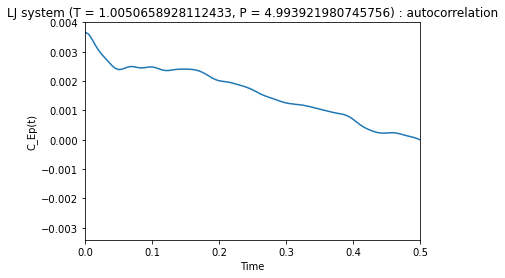

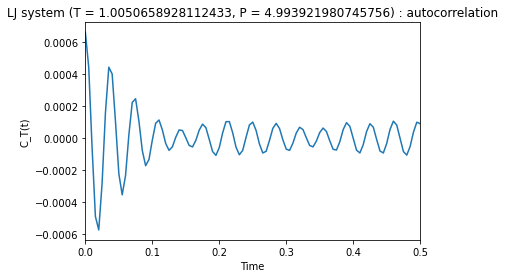

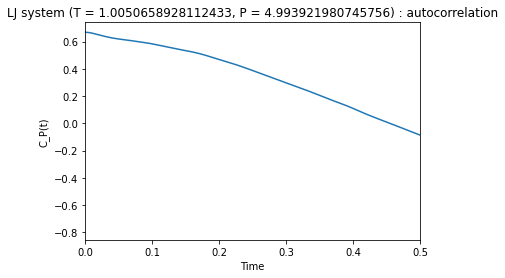

In [12]:
Ep_fluct = Ep[thermal_step+1:] - Ep[thermal_step+1:].mean()
T_fluct = (Ek[thermal_step+1:]- Ek[thermal_step+1:].mean()) * 2.0/3.0
P_fluct = Pressure[thermal_step+1:] - Pressure[thermal_step+1:].mean()

ave_T = Ek[thermal_step+1:].mean() * 2.0 / 3.0
ave_P = Pressure[thermal_step+1:].mean()
print("Average temperature = "+repr(ave_T))
print("Average pressure = "+repr(ave_P))

cor_Ep = np.correlate(Ep_fluct,Ep_fluct,mode="full")
cor_Ep = cor_Ep[cor_Ep.size//2:]/np.arange(Ep_fluct.size,0,-1)
cor_T = np.correlate(T_fluct,T_fluct,mode="full")
cor_T = cor_T[cor_T.size//2:]/np.arange(T_fluct.size,0,-1)
cor_P = np.correlate(P_fluct,P_fluct,mode="full")
cor_P = cor_P[cor_P.size//2:]/np.arange(P_fluct.size,0,-1)

pyplot.figure()
pyplot.title("LJ system (T = "+repr(ave_T) +", P = "+repr(ave_P) +") :"+ " autocorrelation")
pyplot.xlabel("Time")
pyplot.ylabel("C_Ep(t)")
pyplot.plot(np.arange(cor_Ep.size)*dt,cor_Ep)
pyplot.xlim([0,correlation_step*dt])

pyplot.figure()
pyplot.title("LJ system (T = "+repr(ave_T) +", P = "+repr(ave_P) +") :"+ " autocorrelation")
pyplot.xlabel("Time")
pyplot.ylabel("C_T(t)")
pyplot.plot(np.arange(cor_T.size)*dt,cor_T)
pyplot.xlim([0,correlation_step*dt])

pyplot.figure()
pyplot.title("LJ system (T = "+repr(ave_T) +", P = "+repr(ave_P) +") :"+ " autocorrelation")
pyplot.xlabel("Time")
pyplot.ylabel("C_P(t)")
pyplot.plot(np.arange(cor_P.size)*dt,cor_P)
pyplot.xlim([0,correlation_step*dt])

pyplot.show()

In [13]:
## output integrated correlation time
print("Tau potential energy = " + repr(np.sum(cor_Ep[:correlation_step//output_step])/cor_Ep[0]*dt*output_step))
print("Tau temperature = " + repr(np.sum(cor_T[:correlation_step//output_step])/cor_T[0]*dt*output_step))
print("Tau pressure = " + repr(np.sum(cor_P[:correlation_step//output_step])/cor_P[0]*dt*output_step))

Tau potential energy = 0.3290606902094077
Tau temperature = 0.004845585684409985
Tau pressure = 0.4115177443593474
